## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Калашников Дмитрий Павлович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from math import sqrt
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [5]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:
images_train, labels_train = next(iter(train_loader))

In [9]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

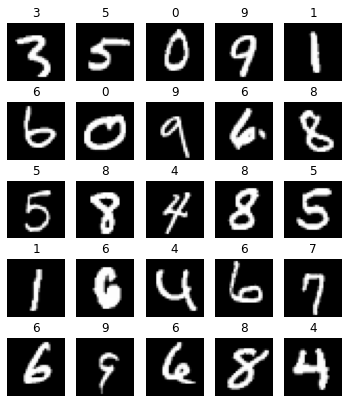

In [10]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [34]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)
    

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward: ', std)

    
def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward: ', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [42]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output) # 2
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output))
    #xavier_init_layer(layer, 0.0, xavier(size_input, size_output))
    
    layers.append(layer)
    layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    #layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [43]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward:  0.9773243069648743
forward:  0.7034493684768677
forward:  0.5615335702896118
forward:  0.5086610317230225
forward:  0.39332315325737
forward:  0.3239736557006836
forward:  0.284025102853775
forward:  0.26865968108177185
forward:  0.2471981942653656
forward:  0.24409066140651703
forward:  0.2268894761800766
forward:  0.18773281574249268
forward:  0.17326048016548157
forward:  0.17349828779697418
forward:  0.18911750614643097
forward:  0.15363822877407074
forward:  0.1413649469614029
forward:  0.14171898365020752
forward:  0.13463830947875977
forward:  0.09285525232553482
forward:  0.09279089421033859
forward:  0.08967507630586624
forward:  0.0920431837439537
forward:  0.10231083631515503
forward:  0.12890908122062683
forward:  0.13984733819961548
forward:  0.14743247628211975
forward:  0.1583230048418045
forward:  0.12242598831653595
forward:  0.09679070860147476
forward:  0.08765360713005066
forward:  0.1071263775229454
forward:  0.13041864335536957
backward:  0.0258198883384

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

#### Xavier

In [62]:
def xavier_init_layer(layer, a_range):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-a_range, a_range)
    
def xavier(size_input, size_output):
    d = 6 / (size_input + size_output)
    return np.sqrt(d)

In [122]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    xavier_init_layer(layer, xavier(size_input, size_output))
    
    layers.append(layer)
    layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    #layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


In [123]:
network = nn.Sequential(*layers)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward:  0.9773243069648743
forward:  0.6970350742340088
forward:  0.5856195688247681
forward:  0.5017008781433105
forward:  0.4082992374897003
forward:  0.35647693276405334
forward:  0.3258931338787079
forward:  0.3183591067790985
forward:  0.2406577318906784
forward:  0.23056615889072418
forward:  0.21975521743297577
forward:  0.23726658523082733
forward:  0.20482692122459412
forward:  0.2236611396074295
forward:  0.24179647862911224
forward:  0.23849482834339142
forward:  0.18591614067554474
forward:  0.17143358290195465
forward:  0.13130517303943634
forward:  0.15812228620052338
forward:  0.15048255026340485
forward:  0.14683280885219574
forward:  0.16212385892868042
forward:  0.17416000366210938
forward:  0.18938249349594116
forward:  0.16460388898849487
forward:  0.14886853098869324
forward:  0.1692461222410202
forward:  0.1313459724187851
forward:  0.12579776346683502
forward:  0.12057169526815414
forward:  0.11737310141324997
forward:  0.09132422506809235
backward:  0.02581988

#### He

In [107]:
def he_init_layer(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)
    
def he_forward(size_input, size_output):
    return sqrt(2 / size_input)

def he_backward(size_input, size_output):
    return sqrt(2 / size_output)

In [118]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    #he_init_layer(layer, 0, he_forward(size_input, size_output))
    he_init_layer(layer, 0, he_backward(size_input, size_output))
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


In [119]:
network = nn.Sequential(*layers)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward:  0.9773243069648743
forward:  2.857541561126709
forward:  3.7886321544647217
forward:  5.874067306518555
forward:  6.164812088012695
forward:  3.963247776031494
forward:  4.704387187957764
forward:  4.049670696258545
forward:  5.039792537689209
forward:  5.347267150878906
forward:  4.203620910644531
forward:  4.728297233581543
forward:  6.371881484985352
forward:  9.508014678955078
forward:  9.185812950134277
forward:  9.799636840820312
forward:  8.004128456115723
forward:  9.507906913757324
forward:  10.6100492477417
forward:  10.767234802246094
forward:  11.909791946411133
forward:  12.559972763061523
forward:  9.87479305267334
forward:  7.19098424911499
forward:  6.150906085968018
forward:  5.969767093658447
forward:  4.997272491455078
forward:  3.1178033351898193
forward:  2.1197431087493896
forward:  1.526737928390503
forward:  1.7200992107391357
forward:  2.004652500152588
forward:  1.8882540464401245
backward:  0.025819888338446617
backward:  0.1329314261674881
backward

<i> 1.4 Сделайте выводы по первой части </i>

Для функции активации Tanh лучше использовать инициализацию Xavier(во избежание стремительных взрывов и затуханий градиентов), для функции активации ReLU лучше использовать инициализацию весов He. Функцию активации Sigmoid лучше не использовать :) (но если и использовать, то скорее с Xavier, чем с He).

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [143]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [34]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

1. TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями

In [145]:
sizes = [196, 128, 128, 10] #[196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append( nn.Linear(size_input, size_output) )
    
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.3))

del layers[-2:]

Epoch 9... (Train/Test) NLL: 0.082/0.057	Accuracy: 0.975/0.981


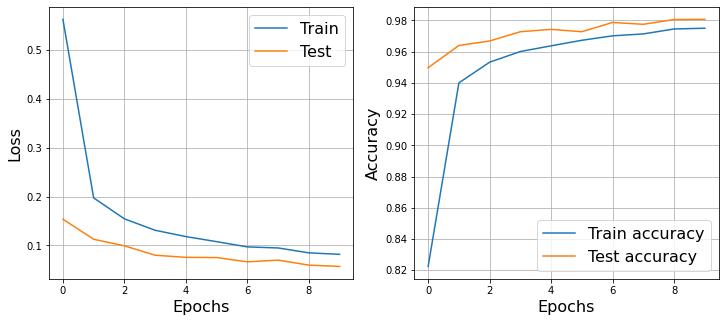

CPU times: user 4min 27s, sys: 26.1 s, total: 4min 53s
Wall time: 5min 4s


([0.5630369670609675,
  0.19725280140699353,
  0.15441013968734343,
  0.13097610270608462,
  0.11807551098737254,
  0.10766415002503629,
  0.09691800939232938,
  0.09476068534894284,
  0.0847361341341218,
  0.08168708473078605],
 [0.15361423979077157,
  0.11257520582102522,
  0.0991497649280708,
  0.07987580674735806,
  0.07548717386973432,
  0.07514072180124401,
  0.0662908707214873,
  0.06984862742969129,
  0.05958334104264084,
  0.05688486956767266],
 [0.8224558,
  0.9399542,
  0.9532028,
  0.9600213,
  0.9636749,
  0.967223,
  0.97006595,
  0.9713042,
  0.9744581,
  0.97494113],
 [0.94966376,
  0.96390426,
  0.96677214,
  0.9727057,
  0.9741891,
  0.9727057,
  0.97863925,
  0.9774525,
  0.9805182,
  0.9806171])

In [146]:
%%time

from train_utils import train
network = TestNetwork( nn.Sequential(*layers) )

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев

In [139]:
layers = [nn.ReLU(), DropConnect(196, 10, p=0.3)]

Epoch 9... (Train/Test) NLL: 0.359/0.278	Accuracy: 0.885/0.952


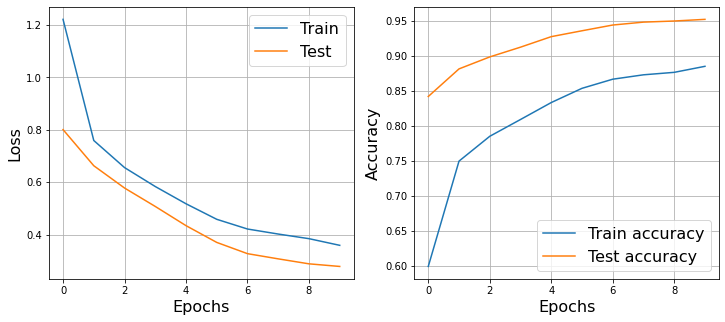

CPU times: user 4min 3s, sys: 10.8 s, total: 4min 14s
Wall time: 4min 13s


([1.2211902923167133,
  0.7588739789752309,
  0.6555166944130651,
  0.5831846030536236,
  0.5174129418472746,
  0.45808151160984406,
  0.42102752756208245,
  0.4018410948802159,
  0.3842131193322159,
  0.3587887355767842],
 [0.8004980411710618,
  0.6625353429890886,
  0.5775141368938398,
  0.507151694614676,
  0.43389009259924105,
  0.36990675367886505,
  0.32696689325797407,
  0.3071512625187258,
  0.28816813588896883,
  0.27819894197620926],
 [0.598764,
  0.7493115,
  0.7847926,
  0.80880195,
  0.8330279,
  0.853356,
  0.86639345,
  0.87267345,
  0.87619936,
  0.8848059],
 [0.84167325,
  0.88113135,
  0.89823973,
  0.9121835,
  0.9272152,
  0.935621,
  0.9438291,
  0.9479826,
  0.9495649,
  0.9519383])

In [140]:
%%time

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Архитектура с финальными линейными слоям с ReLU + Dropout в данном случае сработала лучше, чем ReLU + DropConnect вместо линейных слоев

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [31]:
class LayerNormalization(nn.Module):
    def __init__(self, normalized_shape):
        super(LayerNormalization, self).__init__()
        self.gamma = torch.nn.Parameter(data=torch.ones(normalized_shape), requires_grad=True)
        self.bias = torch.nn.Parameter(data=torch.zeros(normalized_shape), requires_grad=True)
    
    def forward(self, x):
        mean = x.mean( dim = list(range( 1, len(x.size()) )), keepdim=True )
        std = x.std( dim = list(range( 1, len(x.size()) )), keepdim=True )
        output = (x - mean) / (std + 1e-5) * self.gamma + self.bias
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 

Обучаемые параметры в BatchNorm и LayerNorm:

In [48]:
for p in nn.BatchNorm1d(10).parameters():
    if p.requires_grad:
        print(p.data)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [49]:
for p in LayerNormalization(10).parameters():
    if p.requires_grad:
        print(p.data)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Сравнение:

In [32]:
sizes = [196, 128, 128, 10]
layers = []

for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append( nn.Linear(size_input, size_output) )
    layers.append(nn.ReLU())
    layers.append(nn.BatchNorm1d(size_output))

del layers[-2:]

Epoch 9... (Train/Test) NLL: 0.026/0.054	Accuracy: 0.991/0.983


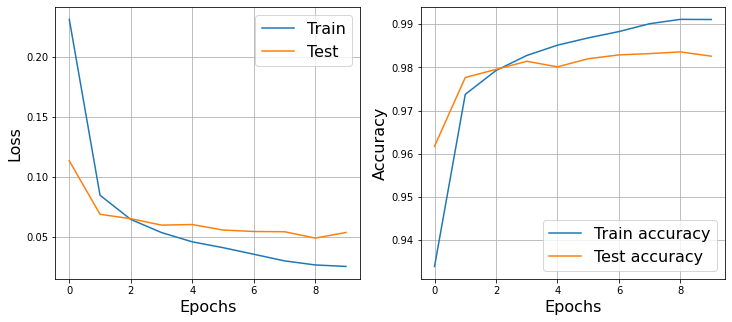

([0.23148442599088398,
  0.08493420694754131,
  0.06479032125983283,
  0.05385276935359181,
  0.04613035640764688,
  0.041271504125933146,
  0.03580040522545243,
  0.030255481562783706,
  0.026871863659769138,
  0.025622448143013107],
 [0.11364022515053991,
  0.06906941831347686,
  0.06541475195060426,
  0.06006301334717228,
  0.06054362499072582,
  0.05596533938476085,
  0.05474397149880098,
  0.05454605350070456,
  0.04926009039701069,
  0.05391596591607019],
 [0.9338908,
  0.97375286,
  0.97927773,
  0.98275363,
  0.9851413,
  0.9868292,
  0.98829514,
  0.9901164,
  0.9911214,
  0.99108255],
 [0.96172863,
  0.97765034,
  0.97952926,
  0.98140824,
  0.9801226,
  0.9820016,
  0.9828916,
  0.9831883,
  0.98358387,
  0.9825949])

In [35]:
from train_utils import train
network = TestNetwork( nn.Sequential(*layers) )

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [36]:
sizes = [196, 128, 128, 10]
layers = []

for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append( nn.Linear(size_input, size_output) )
    layers.append(nn.ReLU())
    layers.append(LayerNormalization(size_output))

del layers[-2:]

Epoch 9... (Train/Test) NLL: 0.024/0.076	Accuracy: 0.992/0.979


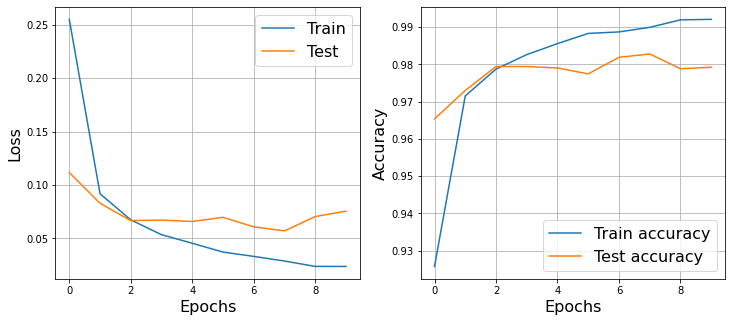

([0.25484995288984863,
  0.091816236755487,
  0.06740474386978695,
  0.05354984222984772,
  0.04551407689653607,
  0.03730161800813764,
  0.033258883561293626,
  0.02891150371296637,
  0.023909794986059368,
  0.02385972888925786],
 [0.11169651697708081,
  0.08289217311134443,
  0.06673944732056389,
  0.06716379675354008,
  0.06591051747385837,
  0.06980267261402516,
  0.06086369545517277,
  0.05710657407187774,
  0.07048017094486475,
  0.07554889373522534],
 [0.92577845,
  0.97154295,
  0.9787447,
  0.9826204,
  0.9855799,
  0.9883174,
  0.98871714,
  0.9899387,
  0.99195427,
  0.99208754],
 [0.96538764,
  0.9730024,
  0.9794304,
  0.9794304,
  0.9790348,
  0.9774525,
  0.9819027,
  0.98279274,
  0.978837,
  0.9792326])

In [37]:
from train_utils import train
network = TestNetwork( nn.Sequential(*layers) )

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

BatchNorm и LayerNorm сравнимы по качеству.